In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
import torch as th
import numpy as np
import numpy.linalg as la
from torch import jit
from torch import optim
import joblib as jl
from torch import nn
from dynrn.rnntasks import DriscollTasks, itiexp
from dynrn.limit_sets import is_converging, velocities
from cmap import Colormap
from sklearn.decomposition import PCA
import dynrn.basic_rnns as rnns
from dynrn.viz import util as vu, dynamics as vd
from scipy.stats import uniform, norm

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import scipy.stats
from pathlib import Path
import tqdm
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
t20 = lambda x: getc(f"seaborn:tab20{x}")
colors, plotter = styles.init_plt(
    '../plots/notebook/driscoll-noise',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

In [4]:
# cuda setup
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(device.type)

cpu


#### noise generating functions

In [35]:
def fftnoise(f, rng):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = rng.uniform(size = Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def lowpass_noise(max_freq, samples=1024, samplerate=1, size = (), seed = 0):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    rng = np.random.default_rng(seed)

    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=0, freqs<=max_freq))[0]
    f[idx] = 1

    ret = np.zeros(size + (samples,))
    for i in np.ndindex(size):
        ret[i] = fftnoise(f, rng)
    return ret

def normalize_range(x, y, axis = None):
    """
    Normalize x to the range of y.

    Parameters
    ----------
    x : np.ndarray
        The data to normalize.
    y : np.ndarray
        The data to normalize to.
    axis : int, or tuple[int], optional
        The axis along which to measure max and min. The default is None.
    """
    vmin = x.min(axis = axis, keepdims=True)
    vmax = x.max(axis = axis, keepdims=True)
    ymin = y.min(axis = axis, keepdims=True)
    ymax = y.max(axis = axis, keepdims=True)
    return (x - vmin) / (vmax - vmin) * (ymax - ymin) + ymin

def normalize_stats(x, y, axis = None):
    """
    Normalize x to the mean and std of y.

    Parameters
    ----------
    x : np.ndarray
        The data to normalize.
    y : np.ndarray
        The data to normalize to.
    axis : int, or tuple[int], optional
        The axis along which to measure mean and std. The default is None.
    """
    xmean = x.mean(axis = axis, keepdims=True)
    ymean = y.mean(axis = axis, keepdims=True)
    xstd = x.std(axis = axis, keepdims=True)
    ystd = y.std(axis = axis, keepdims=True)
    return (x - xmean) / xstd * ystd + ymean

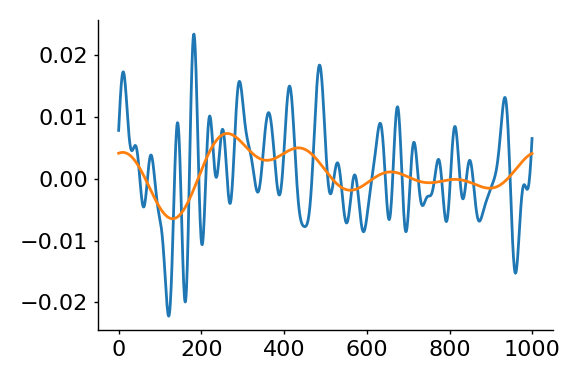

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(lowpass_noise(30, samples = 1000, samplerate = 1000))
ax.plot(lowpass_noise(5, samples = 1000, samplerate = 1000))
plotter.finalize(fig, None)

#### trajectory generating functions

In [ ]:
### scalar instead of boolean values of flags
